In [11]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm
import h5py
import sklearn
import pandas as pd
import nltk
import os
import numpy as np
from wordcloud import WordCloud

In [22]:
# simple way to load the complete dataset (for a more sophisticated generator example, see LLD-logo script)
# open hdf5 file
hdf5_file = h5py.File('LLD-icon.hdf5', 'r')
# load data into memory as numpy array
images, labels = (hdf5_file['data'][:], hdf5_file['labels/resnet/rc_64'][:])


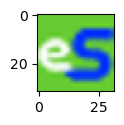

In [29]:
# Investigate the icon data using matplotlib
fig = plt.figure(figsize=(1, 1))
plt.imshow(np.transpose(images[20], (1, 2, 0)))

In [ ]:
# Initiate a GAN model using tensorflow & keras
# Generator
latent_dim = 100
generator = keras.Sequential()
generator.add(layers.Dense(256 activation="relu", input_dim=latent_dim))
generator.add(layers.Dense(512, activation="relu", input_dim=latent_dim))
generator.add(layers.Dense(1024, activation="relu", input_dim=latent_dim))
generator.add(layers.Dense(784, activation="relu", input_dim=latent_dim))
generator.add(layers.Reshape((28, 28, 1)))

# Discriminator
discriminator = keras.Sequential()
discriminator.add(layers.Flatten(input_shape=(28, 28, 1)))
discriminator.add(layers.Dense(1024, activation='relu'))
discriminator.add(layers.Dense(512, activation='relu'))
discriminator.add(layers.Dense(256, activation='relu'))
discriminator.add(layers.Dense(1, activation='sigmoid'))

# Compile Discriminator
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# Combine the discriminator and generator into the GAN model.
discriminator.trainable = False
gan = keras.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='adam')


In [ ]:
def generate_noise(n_samples, noise_dim):
    X = np.random.normal(0, 1, size=(n_samples, noise_dim))
    return X

# Create a function to generate a batch of fake images
def generate_fake_samples(generator, n_samples, noise_dim):
    noise = generate_noise(n_samples, noise_dim)
    fake_logos = generator.predict(noise)
    return fake_logos

# Train the GAN model
def train_gan(generator, discriminator, gan, real_logos, n_epochs, batch_size, latent_dim):
    n_batches = int(real_logos.shape[0] // batch_size)
    
    for epoch in range(n_epochs):
        for batch in range(n_batches):
            batch_indices = np.random.randint(0, real_logos.shape[0], size=batch_size)
            real_batch = real_logos[batch_indices]
            
            noise = generate_noise(batch_size, latent_dim)
            fake_batch = generator.predict(noise)
            
            X = np.concatenate([real_batch, fake_batch])
            y = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
            discriminator_loss = discriminator.train_on_batch(X, y)
            
            # Train the Generator
            noise = generate_noise(batch_size, latent_dim)
            y = np.ones((batch_size, 1))
            generator_loss = gan.train_on_batch(noise, y)